In [ ]:
Afrom pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("SalePrediction") \
    .getOrCreate()

# Load the CSV data into a Spark DataFrame
data_path = '/content/drive/MyDrive/School/Scalable/Project/sales_data_sample.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Show schema and first few rows
df.printSchema()
df.show(5)


root
 |-- ORDERNUMBER: integer (nullable = true)
 |-- QUANTITYORDERED: integer (nullable = true)
 |-- PRICEEACH: double (nullable = true)
 |-- ORDERLINENUMBER: integer (nullable = true)
 |-- SALES: double (nullable = true)
 |-- ORDERDATE: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- QTR_ID: integer (nullable = true)
 |-- MONTH_ID: integer (nullable = true)
 |-- YEAR_ID: integer (nullable = true)
 |-- PRODUCTLINE: string (nullable = true)
 |-- MSRP: integer (nullable = true)
 |-- PRODUCTCODE: string (nullable = true)
 |-- CUSTOMERNAME: string (nullable = true)
 |-- PHONE: string (nullable = true)
 |-- ADDRESSLINE1: string (nullable = true)
 |-- ADDRESSLINE2: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- POSTALCODE: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- TERRITORY: string (nullable = true)
 |-- CONTACTLASTNAME: string (nullable = true)
 |-- CONTACTFIRSTNAME: string (nullable = tr

# **Cleaning-Drop null**

In [ ]:
from pyspark.sql.functions import col, to_date

# Drop duplicates and rows with null values
df_clean = df.dropDuplicates().na.drop()

# Convert ORDERDATE to proper date format
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
df_clean = df_clean.withColumn("ORDERDATE", to_date("ORDERDATE", "M/d/yyyy H:mm"))

# Cast SALES to double and filter out non-positive values
df_clean = df_clean.withColumn("SALES", col("SALES").cast("double"))
df_clean = df_clean.filter(col("SALES") > 0)

# Drop unnecessary columns
df_clean = df_clean.drop("ADDRESSLINE2", "PHONE", "POSTALCODE")

# Show cleaned data
df_clean.printSchema()
df_clean.show(5)


root
 |-- ORDERNUMBER: integer (nullable = true)
 |-- QUANTITYORDERED: integer (nullable = true)
 |-- PRICEEACH: double (nullable = true)
 |-- ORDERLINENUMBER: integer (nullable = true)
 |-- SALES: double (nullable = true)
 |-- ORDERDATE: date (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- QTR_ID: integer (nullable = true)
 |-- MONTH_ID: integer (nullable = true)
 |-- YEAR_ID: integer (nullable = true)
 |-- PRODUCTLINE: string (nullable = true)
 |-- MSRP: integer (nullable = true)
 |-- PRODUCTCODE: string (nullable = true)
 |-- CUSTOMERNAME: string (nullable = true)
 |-- ADDRESSLINE1: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- TERRITORY: string (nullable = true)
 |-- CONTACTLASTNAME: string (nullable = true)
 |-- CONTACTFIRSTNAME: string (nullable = true)
 |-- DEALSIZE: string (nullable = true)

+-----------+---------------+---------+---------------+-------+----------+------

# **Preproccess**

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Step 1: Select relevant features (remove high-cardinality or unnecessary ones)
features = [
    "QUANTITYORDERED", "PRICEEACH", "ORDERLINENUMBER",
    "SALES", "QTR_ID", "MONTH_ID", "YEAR_ID",
    "MSRP", "STATUS", "PRODUCTLINE", "DEALSIZE"
]

# Step 2: String indexing for categorical columns
categorical_cols = ["STATUS", "PRODUCTLINE", "DEALSIZE"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid='keep') for col in categorical_cols]

# Step 3: Index the label column 'SALES'
label_indexer = StringIndexer(inputCol="SALES", outputCol="label", handleInvalid='keep')

# Step 4: Assemble features into a single vector
assembler_inputs = [col + "_index" for col in categorical_cols] + [
    "QUANTITYORDERED", "PRICEEACH", "ORDERLINENUMBER",
    "SALES", "QTR_ID", "MONTH_ID", "YEAR_ID", "MSRP"
]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features_unscaled")

# Step 5: Standardize features (recommended for many ML algorithms)
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features")

# Step 6: Build pipeline
pipeline = Pipeline(stages=indexers + [label_indexer, assembler, scaler])

# Step 7: Fit and transform the cleaned DataFrame
df_prepared = pipeline.fit(df_clean).transform(df_clean)

# Step 8: Split into train/test sets
train_data, test_data = df_prepared.randomSplit([0.8, 0.2], seed=42)

# Optional: Check the schema and sample
df_prepared.select("features", "label").show(5, truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                      |label|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|[0.0,0.6579436879050725,0.0,3.2732510593323747,4.943172002472396,0.50905015832459,1.7935645353652836,3.5404026413230687,2.73548195797726,2985.2301315723025,2.4755558461997724]               |128.0|
|[0.0,0.6579436879050725,0.0,3.590017290880669,4.943172002472396,1.5271504749737699,2.0860170183958826,3.5404026413230687,3.282578349572712,2986.7205110688437,1.5931795049800517]             |153.0|
|[0.0

# Model Development

In [ ]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import PipelineModel

# Define models
models = {
    "LinearRegression": LinearRegression(featuresCol="features", labelCol="label"),
    "RandomForest": RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=100),
    "GBT": GBTRegressor(featuresCol="features", labelCol="label", maxIter=100),
    "DecisionTree": DecisionTreeRegressor(featuresCol="features", labelCol="label")
}

# Evaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

best_model = None
best_model_name = ""
best_rmse = float("inf")

# Train and evaluate all models
for name, model in models.items():
    print(f"Training {name}...")
    fitted_model = model.fit(train_data)
    predictions = fitted_model.transform(test_data)
    rmse = evaluator.evaluate(predictions)
    print(f"{name} RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = fitted_model
        best_model_name = name

Training LinearRegression...
LinearRegression RMSE: 13.1045
Training RandomForest...
RandomForest RMSE: 22.3598
Training GBT...
GBT RMSE: 3.3713
Training DecisionTree...
DecisionTree RMSE: 4.0020


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Predict using the best model
best_predictions = best_model.transform(test_data)

# Initialize evaluators
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mse  = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
evaluator_r2   = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
evaluator_mae  = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")

# Calculate metrics
rmse = evaluator_rmse.evaluate(best_predictions)
mse  = evaluator_mse.evaluate(best_predictions)
r2   = evaluator_r2.evaluate(best_predictions)
mae  = evaluator_mae.evaluate(best_predictions)

# Print metrics
print("\n📊 Evaluation Metrics for Best Model:")
print(f"Model: {best_model_name}")
print(f"RMSE : {rmse:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")



📊 Evaluation Metrics for Best Model:
Model: GBT
RMSE : 3.3713
MSE  : 11.3659
MAE  : 2.6829
R²   : 0.9974


In [ ]:
best_model.save(f"/content/drive/MyDrive/School/Scalable/Project/best_model_{best_model_name}")
print(f"Best model '{best_model_name}' saved successfully.")


Best model 'GBT' saved successfully.


In [ ]:
from pyspark.ml.regression import GBTRegressionModel

# Load the saved GBT model
loaded_model = GBTRegressionModel.load("/content/drive/MyDrive/School/Scalable/Project/best_model_GBT")

# (Optional) Test that it works by making predictions
loaded_predictions = loaded_model.transform(test_data)
loaded_predictions.select("prediction", "label").show(5)


+------------------+-----+
|        prediction|label|
+------------------+-----+
|101.82992496331579|105.0|
| 121.6910864914271|124.0|
|129.05296390020297|133.0|
| 98.49987621721392|103.0|
|243.67264130151625|248.0|
+------------------+-----+
only showing top 5 rows



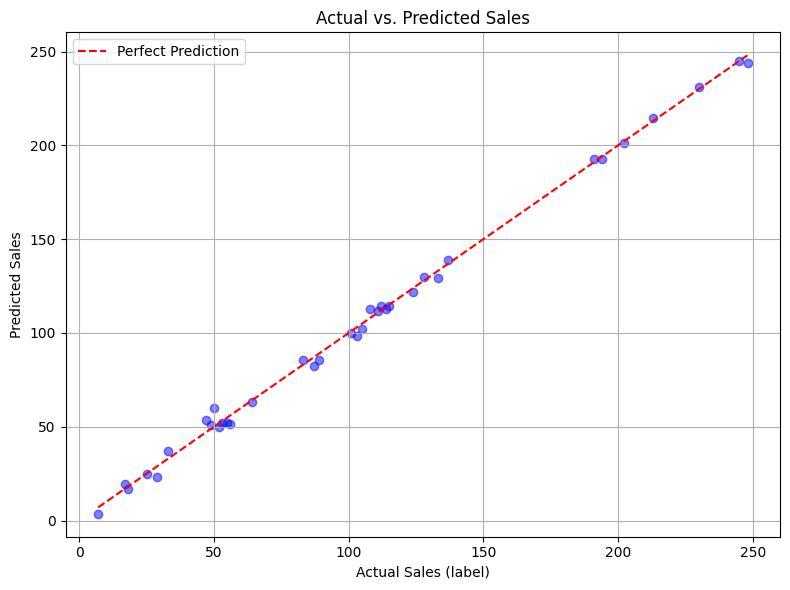

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Predict using the loaded model
predictions = loaded_model.transform(test_data)

# Step 2: Select actual and predicted values, convert to pandas
pred_df = predictions.select("label", "prediction").toPandas()

# Step 3: Plot actual vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(pred_df["label"], pred_df["prediction"], alpha=0.5, color='blue')
plt.plot([pred_df["label"].min(), pred_df["label"].max()],
         [pred_df["label"].min(), pred_df["label"].max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Sales (label)")
plt.ylabel("Predicted Sales")
plt.title("Actual vs. Predicted Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
test_data.show()

+-----------+---------------+---------+---------------+-------+----------+-------+------+--------+-------+----------------+----+-----------+--------------------+--------------------+------------+--------+---------+---------+---------------+----------------+--------+------------+-----------------+--------------+-----+--------------------+--------------------+
|ORDERNUMBER|QUANTITYORDERED|PRICEEACH|ORDERLINENUMBER|  SALES| ORDERDATE| STATUS|QTR_ID|MONTH_ID|YEAR_ID|     PRODUCTLINE|MSRP|PRODUCTCODE|        CUSTOMERNAME|        ADDRESSLINE1|        CITY|   STATE|  COUNTRY|TERRITORY|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|STATUS_index|PRODUCTLINE_index|DEALSIZE_index|label|   features_unscaled|            features|
+-----------+---------------+---------+---------------+-------+----------+-------+------+--------+-------+----------------+----+-----------+--------------------+--------------------+------------+--------+---------+---------+---------------+----------------+--------+------------

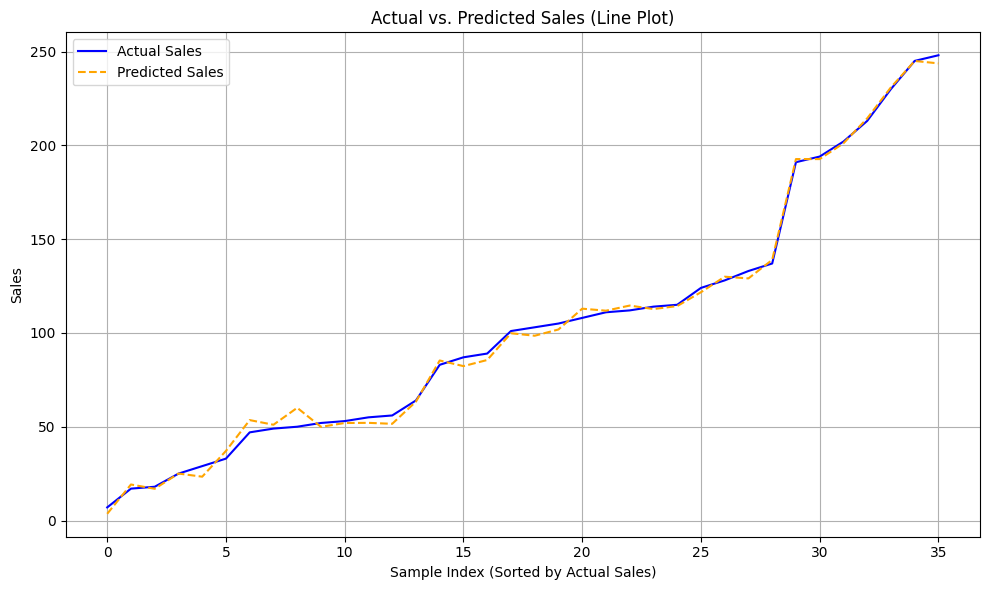

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Predict using the loaded model
predictions = loaded_model.transform(test_data)

# Convert to pandas DataFrame
pred_df = predictions.select("label", "prediction").toPandas()

# Sort by actual values or index for better curve continuity
pred_df = pred_df.sort_values(by="label").reset_index(drop=True)

# Plot as lines
plt.figure(figsize=(10, 6))
plt.plot(pred_df["label"], label="Actual Sales", color='blue')
plt.plot(pred_df["prediction"], label="Predicted Sales", color='orange', linestyle='--')
plt.title("Actual vs. Predicted Sales (Line Plot)")
plt.xlabel("Sample Index (Sorted by Actual Sales)")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
